# Loading

In [ ]:
!pip install scanpy
!pip install bbknn
!pip install leidenalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
import json
import anndata

In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
cancer_json={}
for i in cancer1:
  with open("/content/drive/MyDrive/SL/data/dpt/{0}_dpt_json.json".format(i),"r") as f:
    p=json.load(f)
  cancer_json[i]=p
cancer_json

{'KIDNEY': {'Dendritic cell': [9, 18, 17, 8, 6],
  'Macrophage': [9, 18, 17, 6, 0, 7, 10, 15],
  'Microglial cell': [9, 18, 17, 7, 11],
  'Monocyte': [9, 18, 17, 4, 3, 2, 1, 5, 14]},
 'esca': {'Dendritic cell': [5, 4, 12],
  'Macrophage': [5, 11, 10],
  'Microglial cell': [5, 15],
  'Monocyte': [5, 9, 1, 2, 3, 13]},
 'lym': {'Dendritic cell': [4, 6, 5, 8],
  'Macrophage': [4, 3, 2],
  'Microgial cell': [4, 3],
  'Monocyte': [4, 6, 5, 0, 1]},
 'mye': {'Dendritic cell': [7, 12, 13, 15],
  'Monocyte': [7, 10, 14, 6, 11, 0, 1, 2],
  'Neutrophil': [7, 10, 5, 3]},
 'ov-ftc': {'Dendritic cell': [9, 8],
  'Macrophage': [9, 7],
  'Microgilal cell': [9, 2, 4],
  'Monocyte': [9, 7, 3]},
 'paad': {'Dendritic cell': [7, 11, 2],
  'Macrophage': [7, 8],
  'Microglial cell': [7, 3, 9],
  'Monocyte': [7, 6, 14]},
 'thca': {'Dendritic cell': [3, 12, 13, 4, 15, 19, 5],
  'Macrophage': [3, 10, 12],
  'Microglial cell': [3, 12, 11, 2, 0],
  'Monocyte': [3, 6, 1, 9]},
 'ucec': {'Dendritic cell': [1, 4, 14],

In [ ]:
import seaborn as sns
heat=pd.DataFrame(columns=['Dendritic cell','Macrophage','Microglial cell','Monocyte','Neutrophil'],dtype=np.float64)
for i in cancer1:
  test1={}
  for j in ['Dendritic cell','Macrophage','Microglial cell','Monocyte','Neutrophil']:
    if j in cancer_json[i].keys():
      test1[j]=1
    else:
      test1[j]=0
  heat.loc[i]=test1
heat.index=cancer
heat

,Dendritic cell,Macrophage,Microglial cell,Monocyte,Neutrophil
ESCA,1.0,1.0,1.0,1.0,0.0
KIDNEY,1.0,1.0,1.0,1.0,0.0
LYM,1.0,1.0,0.0,1.0,0.0
MYE,1.0,0.0,0.0,1.0,1.0
OV-FTC,1.0,1.0,0.0,1.0,0.0
PAAD,1.0,1.0,1.0,1.0,0.0
THCA,1.0,1.0,1.0,1.0,0.0
UCEC,1.0,0.0,1.0,1.0,1.0


In [ ]:
SL_pd=pd.read_csv('/content/drive/MyDrive/SL/sl-for-scrnaseq-full.csv')
SL_pd.head()

,gene1,gene2
0,ITGB1,BCL2
1,ANXA5,DUSP18
2,CYBA,ZFP36L1
3,CTSC,S100A11
4,CTSD,WIPI2


# get_SL_result

In [ ]:
def get_SL_result(adata,cancer,trajectory):
  print('......Analysis SL_count')
  xl=adata.var.index.tolist()
  SL=pd.DataFrame(columns=['gene1','gene2'])
  ret3= list(set(xl).intersection(SL_pd['gene1'].values))
  for i in ret3:
    ret4=list(set(ret3).intersection(SL_pd.loc[SL_pd['gene1']==i]['gene2'].values))
    for j in ret4: 
      SL=SL.append({'gene1':i,'gene2':j},ignore_index=True)

  ret5= list(set(xl).intersection(SL_pd['gene2'].values))
  for i in ret5:
    ret6=list(set(ret5).intersection(SL_pd.loc[SL_pd['gene2']==i]['gene1'].values))
    for j in ret6: 
      SL=SL.append({'gene1':j,'gene2':i},ignore_index=True)
  SL=SL.drop_duplicates(keep='first')

  sl_len=len(SL)
  for i in range(sl_len):
    if(i==sl_len):
      break
    if(SL.iloc[i]['gene1']==SL.iloc[i]['gene2']):
      print(i)
      SL=SL.drop(SL.iloc[i].name)
      sl_len-=1


  SL_li=SL['gene1'].values.tolist()+SL['gene2'].values.tolist()
  SL_li=list(set(SL_li))
  #Count
  SL_count=pd.DataFrame()
  SL_count['X']=adata.obs.dpt_pseudotime
  for i in SL_li:
    SL_count[i]=adata[:,i].X
  SL_count_sort=SL_count.sort_values(by='X')

  print('......Analysis SL_slope')
  import scipy.stats as stats
  slope_pd=pd.DataFrame(columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err','average','active','sig'])
  for i in SL_count_sort.columns[1:]: 
    if len(SL_count_sort[SL_count_sort[i]!=0].values)==0:
      slope, intercept, r_value, p_value, std_err=0,0,0,0,0
    else:  
      slope, intercept, r_value, p_value, std_err=stats.linregress(SL_count_sort[SL_count_sort[i]!=0]['X'].values, SL_count_sort[SL_count_sort[i]!=0][i].values)
    average=np.average(SL_count_sort[i].values)
    active='T'
    if(average <0.01 and average>-0.01):
      active='F'
    sig='normal'
    #cs=mk.original_test(SL_count_sort[SL_count_sort[i]!=0][i].values)
    if(slope>0):
      sig='high'
    elif(slope<0):
      sig='low'
    slope_pd.loc[i]=[slope, intercept, r_value, p_value, std_err,average,active,sig]
  #
  print('......Analysis SL_p')
  SL_p=pd.DataFrame(columns=['dp','type'])
  for i in range(len(SL)):
    test=[]
    g1,g2=(SL.iloc[i]['gene1']),(SL.iloc[i]['gene2'])
    #test.append(SL_count_sort[g1].values)
    #test.append(SL_count_sort[g2].values)
    #test=np.array(test)
    ty=0
    if(slope_pd.loc[g1]['active']=='T' and slope_pd.loc[g1]['sig']=='high'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=1
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=4
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=3
    if(slope_pd.loc[g1]['active']=='T' and slope_pd.loc[g1]['sig']=='low'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=2
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=3
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=5
    if(slope_pd.loc[g1]['active']=='F'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=6
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=1
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=2

    SL_p.loc[g1+'-'+g2]={'dp':slope_pd.loc[g1]['slope']-slope_pd.loc[g2]['slope'],'type':ty}
    #PCA(n_components=1).fit_transform(test.T).T[0]
  SL_p.head()

  SL_count_sort.to_csv('/content/drive/MyDrive/SL/data/result2/{0}_{1}_SL_count.csv'.format(cancer,trajectory))
  slope_pd.to_csv('/content/drive/MyDrive/SL/data/result2/{0}_{1}_SL_slope.csv'.format(cancer,trajectory))
  SL_p.to_csv('/content/drive/MyDrive/SL/data/result2/{0}_{1}_SL_pair_type.csv'.format(cancer,trajectory))
  return SL_count_sort,slope_pd,SL_p

# Cancer(Mono)

In [ ]:
from SL_Function import SL_Analysis

In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
#cancer2=['esca','lym','mye','ov-ftc','paad','thca','ucec']
#cancer3=['ESCA','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
import anndata
for i in range(len(cancer1)):
  adata=anndata.read_h5ad("/content/drive/MyDrive/SL/data/dpt/{0}_dpt.h5ad".format(cancer1[i]))
  adata=adata[adata.obs['tissue']=='T']
  kidney_mono=cancer_json[cancer1[i]]['Monocyte']
  kidney_mono=list(map(str,kidney_mono))
  adata=adata[adata.obs['leiden'].isin(kidney_mono)]
  trajectory='Monocyte'
  sl_a=SL_Analysis(adata,SL_pd)
  sl_a.Lazy_analysis(['SL_count.csv'.format(cancer,trajectory),'SL_slope.csv'.format(cancer,trajectory),'SL_pair.csv'.format(cancer,trajectory)])
  break

......Analysis SL_count
......Analysis SL_slope
......Analysis SL_p


In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
#cancer2=['esca','lym','mye','ov-ftc','paad','thca','ucec']
#cancer3=['ESCA','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
import anndata
for i in range(len(cancer1)):
  adata=anndata.read_h5ad("/content/drive/MyDrive/SL/data/dpt/{0}_dpt.h5ad".format(cancer1[i]))
  adata=adata[adata.obs['tissue']=='T']
  kidney_mono=cancer_json[cancer1[i]]['Monocyte']
  kidney_mono=list(map(str,kidney_mono))
  adata=adata[adata.obs['leiden'].isin(kidney_mono)]
  trajectory='Monocyte'
  SL_count_sort1,slope_pd1,SL_p1=get_SL_result(adata,cancer[i],trajectory)

......Analysis SL_count
2648
7883
12236
18991
28122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


......Analysis SL_slope


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


......Analysis SL_p
......Analysis SL_count
2879
8736
13514
21103
31188
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2042
5941
14343
21082
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2638
7841
12185
18928
27752
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2456
7291
11384
17580
25779
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2466
7451
11504
17675
26163
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2647
7853
12260
18988
27919
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2679
8098
12603
19599
28754
......Analysis SL_slope
......Analysis SL_p


In [ ]:
a1=SL_p1.index.tolist()


1 ['EI24', 'NAE1']
2 ['FEN1', 'SMPD2']
3 ['RNGTT', 'TUBGCP3']
4 ['ARL2', 'RPL24']
5 ['MRPL54', 'RNF126']
6 ['FEN1', 'RAD51']


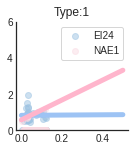

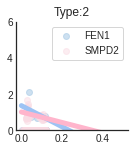

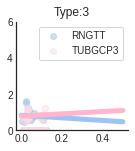

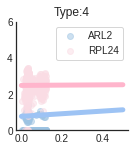

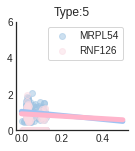

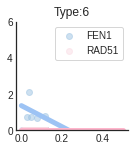

In [ ]:
for i in list(set(SL_p1['type'])):
  print(i,SL_p1[SL_p1['type']==i].iloc[0].name.split('-'))
  plt.style.use('seaborn-white')
  #plt.subplots(figsize=(2,2))

#  g=sns.displot(
#      data=get_disdata(SL_p[SL_p['type']==i].iloc[0].name.split('-')),
#      x='X',hue='gene',
#      kind="kde", 
#      #multiple="fill", clip=(0, None),
#      palette="ch:rot=-.25,hue=1,light=.75",
#      height=2,
#      aspect=1,
#  )

  gene=SL_p1[SL_p1['type']==i].iloc[0].name.split('-')
  gene1,gene2=gene[0],gene[1]
  plt.figure(figsize=(2,2))
  ax=plt.subplot(1, 1, 1)
  p1=plt.scatter(SL_count_sort1['X'].values, SL_count_sort1[gene1].values,alpha=0.5,color='#9DC3E2')
  y1=[slope_pd1.loc[gene1]['slope']*i+slope_pd1.loc[gene1]['intercept'] for i in [0,0.5]]
  p3=plt.plot([0,0.5],y1,alpha=1,color='#9DC3F4',linewidth=5)


  p2=plt.scatter(SL_count_sort1['X'].values, SL_count_sort1[gene2].values,alpha=0.5,color='#FADCE4')
  y1=[slope_pd1.loc[gene2]['slope']*i+slope_pd1.loc[gene2]['intercept'] for i in [0,0.5]]
  p4=plt.plot([0,0.5],y1,alpha=1,color='#FFB5CC',linewidth=5,)

  #plt.legend([p1, p2], [gene1,gene2], bbox_to_anchor=(1, 0), loc=3,)
  plt.legend([p1, p2], [gene1,gene2], loc='best',frameon = True)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(True)
  ax.spines['left'].set_visible(True)

  #g.set_axis_labels("Pseudotime","Density")
  #g.set_titles("Type:1")
  plt.ylim(0,6)
  plt.title('Type:{0}'.format(i))
  plt.savefig('CDC2_Type:{0}'.format(i),dpi=300,bbox_inches = 'tight')

## Count analysis

In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
cancer_slope={}
trajectory='Monocyte'
for i in cancer:
  test_pd=pd.read_csv('/content/drive/MyDrive/SL/data/result2/{0}_{1}_SL_pair_type.csv'.format(i,trajectory))
  test_pd.set_index(test_pd.columns[0],inplace=True)
  cancer_slope[i]=test_pd


In [ ]:
count_pd=pd.DataFrame(columns=['type_1','type_2','type_3','type_4','type_5','type_6'],dtype=int)
for i in cancer:
  count_test={}
  type1=list(set(cancer_slope[i]['type']))
  for j in range(1,7):
    if j in type1:
      count_test['type_{0}'.format(j)]=cancer_slope[i].type.value_counts().loc[j]
    else:
      count_test['type_{0}'.format(j)]=0
  
  count_pd.loc[i]=count_test
count_pd

,type_1,type_2,type_3,type_4,type_5,type_6
ESCA,8178,1767,4900,11994,499,1835
KIDNEY,508,12215,1925,52,23499,2200
LYM,1800,134,3095,21842,121,53
MYE,2938,5353,12518,4199,9802,985
OV-FTC,619,6684,3360,143,21517,745
PAAD,7291,1916,7420,15069,953,1238
THCA,4626,4425,9206,4611,4687,1644
UCEC,1987,10682,5765,553,15686,2491


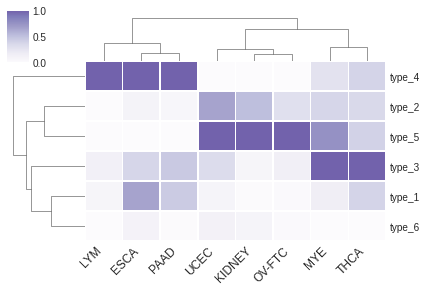

In [ ]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
new_blues=sns.color_palette("Purples", 1000)[0:700]
g=sns.clustermap(count_pd.T,standard_scale=1,
      cmap=new_blues,
      linewidths=.5,annot_kws={"size": 15},figsize=(6,4),
      )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12,rotation=45, horizontalalignment='right',)
#g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15,rotation=360)
#cbar = g.collections[0].colorbar
# here set the labelsize by 20
#cbar.ax.tick_params(labelsize=12)
plt.savefig("fig3_b.png",dpi=300,bbox_inches = 'tight')

(array([ 5, 15, 25, 35, 45, 55, 65, 75]),
 <a list of 8 Text major ticklabel objects>)

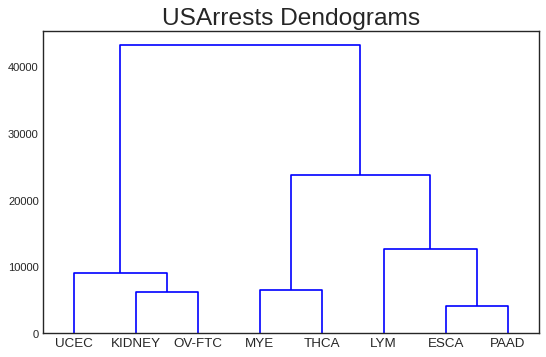

In [ ]:
import scipy.cluster.hierarchy as shc

# import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/USArrests.csv')
#print(df)

# Plot
plt.figure(figsize=(8, 5), dpi= 80)  
plt.title("USArrests Dendograms", fontsize=22)  
dend = shc.dendrogram(shc.linkage(count_pd,
          method='ward'), labels=count_pd.index, color_threshold=100)  

plt.xticks(fontsize=12)

In [ ]:
count_pd

,type_1,type_2,type_3,type_4,type_5,type_6
ESCA,8178,1767,4900,11994,499,1835
KIDNEY,508,12215,1925,52,23499,2200
LYM,1800,134,3095,21842,121,53
MYE,2938,5353,12518,4199,9802,985
OV-FTC,619,6684,3360,143,21517,745
PAAD,7291,1916,7420,15069,953,1238
THCA,4626,4425,9206,4611,4687,1644
UCEC,1987,10682,5765,553,15686,2491


In [ ]:
all_pair=[]
for i in cancer:
  print(i,len(cancer_slope[i].index.tolist()))
  all_pair=all_pair+cancer_slope[i].index.tolist()
all_pair=list(set(all_pair))
print('all',len(all_pair))

ESCA 36382
KIDNEY 40399
LYM 27053
MYE 35795
OV-FTC 33068
PAAD 33887
THCA 36091
UCEC 37164
all 41373


In [ ]:
pair_count=pd.DataFrame(columns=all_pair,dtype=int)
for i in cancer:
  for j in range(1,7):
    t=cancer_slope[i][cancer_slope[i]['type']==j]
    t_ventor={}
    for k in all_pair:
      if k in t.index.tolist():
        t_ventor[k]=1
      else:
        t_ventor[k]=0
    pair_count.loc[i+'-type_{0}'.format(j)]=t_ventor
pair_count.head()
  

,FGD4-TRIM45,PLSCR4-TRPC4AP,ORM1-SCAF11,BAK1-SLC26A7,BLM-HOXC9,DUSP27-KRT8,FRMPD1-NRAS,HRAS-SCFD2,RAP1A-SLC22A1,DHRS1-NRBP1,...,EPB41L1-ABL2,KRAS-PSPH,MUS81-CHERP,NDUFB4-TUBGCP3,GMPS-PRKCA,OTULIN-MYC,PTTG1-CD3EAP,KCNQ3-TFB1M,ATRX-RAD52,MYC-NTAN1
ESCA-type_1,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
ESCA-type_2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
ESCA-type_3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
ESCA-type_4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
ESCA-type_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cancer_count=pd.DataFrame(columns=all_pair,dtype=int)
for i in cancer:
    t=cancer_slope[i]
    t_ventor={}
    for k in all_pair:
      if k in t.index.tolist():
        t_ventor[k]=1
      else:
        t_ventor[k]=0
    cancer_count.loc[i]=t_ventor
cancer_count.head()

,FGD4-TRIM45,PLSCR4-TRPC4AP,ORM1-SCAF11,BAK1-SLC26A7,BLM-HOXC9,DUSP27-KRT8,FRMPD1-NRAS,HRAS-SCFD2,RAP1A-SLC22A1,DHRS1-NRBP1,...,EPB41L1-ABL2,KRAS-PSPH,MUS81-CHERP,NDUFB4-TUBGCP3,GMPS-PRKCA,OTULIN-MYC,PTTG1-CD3EAP,KCNQ3-TFB1M,ATRX-RAD52,MYC-NTAN1
ESCA,1,1,1,0,0,0,1,1,0,1,...,1,1,1,1,1,1,1,0,1,1
KIDNEY,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
LYM,0,0,0,0,0,0,0,1,0,1,...,0,1,1,1,1,1,1,0,0,1
MYE,0,1,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
OV-FTC,1,1,0,0,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
type_count=pd.DataFrame(columns=all_pair)
for j in range(1,7):
  for i in cancer:
    t=cancer_slope[i][cancer_slope[i]['type']==j]
    t_ventor={}
    for k in all_pair:
      if k in t.index.tolist():
        t_ventor[k]=1
      else:
        if k in t_ventor.keys():
          t_ventor[k]+=1
        else:
          t_ventor[k]=0
  type_count.loc['type_{0}'.format(j)]=t_ventor
type_count.head()

,FGD4-TRIM45,PLSCR4-TRPC4AP,ORM1-SCAF11,BAK1-SLC26A7,BLM-HOXC9,DUSP27-KRT8,FRMPD1-NRAS,HRAS-SCFD2,RAP1A-SLC22A1,DHRS1-NRBP1,...,EPB41L1-ABL2,KRAS-PSPH,MUS81-CHERP,NDUFB4-TUBGCP3,GMPS-PRKCA,OTULIN-MYC,PTTG1-CD3EAP,KCNQ3-TFB1M,ATRX-RAD52,MYC-NTAN1
type_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
type_2,1,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,1,0
type_3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
type_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
type_5,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,1,1,0,0,1


In [ ]:
pair_count.to_csv('/content/drive/MyDrive/SL/data/count_result/{0}_SL_pair_count.csv'.format(trajectory))
cancer_count.to_csv('/content/drive/MyDrive/SL/data/count_result/{0}_SL_cancer_count.csv'.format(trajectory))
type_count.to_csv('/content/drive/MyDrive/SL/data/count_result/{0}_SL_type_count.csv'.format(trajectory))

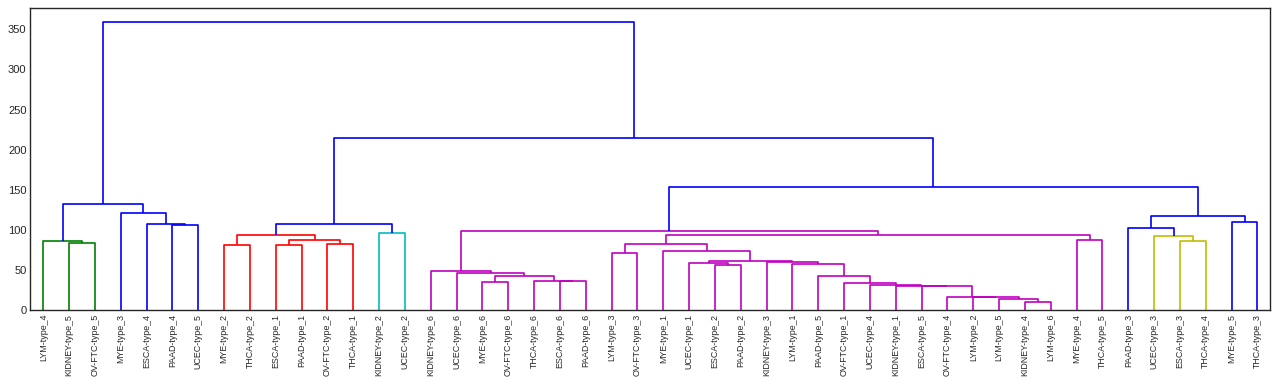

In [ ]:
plt.figure(figsize=(20, 5), dpi= 80)  
dend = shc.dendrogram(shc.linkage(pair_count,
          method='ward'), labels=pair_count.index, color_threshold=100)  

In [ ]:
shc.to_tree(shc.linkage(pair_count,
          method='ward'))

In [ ]:
def get_newick(node, parent_dist, leaf_names, newick='') -> str:
    """
    Convert sciply.cluster.hierarchy.to_tree()-output to Newick format.

    :param node: output of sciply.cluster.hierarchy.to_tree()
    :param parent_dist: output of sciply.cluster.hierarchy.to_tree().dist
    :param leaf_names: list of leaf names
    :param newick: leave empty, this variable is used in recursion.
    :returns: tree in Newick format
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parent_dist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick=newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, newick=",%s" % (newick))
        newick = "(%s" % (newick)
        return newick

tree = shc.to_tree(shc.linkage(pair_count,
          method='ward'))
get_newick(tree, tree.dist, pair_count.index.tolist())

'(((((THCA-type_3:109.85,MYE-type_5:109.85):6.75,(((THCA-type_4:85.94,ESCA-type_3:85.94):6.67,UCEC-type_3:92.60):9.08,PAAD-type_3:101.69):14.92):36.85,(((THCA-type_5:86.73,MYE-type_4:86.73):6.98,((((((((((((((LYM-type_6:10.25,KIDNEY-type_4:10.25):3.57,LYM-type_5:13.82):1.67,LYM-type_2:15.49):0.46,OV-FTC-type_4:15.95):13.43,ESCA-type_5:29.38):0.90,KIDNEY-type_1:30.27):1.18,UCEC-type_4:31.45):1.96,OV-FTC-type_1:33.41):8.32,PAAD-type_5:41.74):15.64,LYM-type_1:57.38):1.76,KIDNEY-type_3:59.14):1.66,((PAAD-type_2:55.94,ESCA-type_2:55.94):2.42,UCEC-type_1:58.36):2.44):12.17,MYE-type_1:72.96):9.02,(OV-FTC-type_3:71.14,LYM-type_3:71.14):10.85):11.73):4.67,(((((PAAD-type_6:36.12,ESCA-type_6:36.12):0.27,THCA-type_6:36.39):6.43,(OV-FTC-type_6:34.70,MYE-type_6:34.70):8.12):3.62,UCEC-type_6:46.44):2.57,KIDNEY-type_6:49.01):49.38):55.07):60.91,((UCEC-type_2:96.18,KIDNEY-type_2:96.18):10.96,(((THCA-type_1:82.41,OV-FTC-type_2:82.41):4.60,(PAAD-type_1:81.15,ESCA-type_1:81.15):5.87):6.21,(THCA-type_2:80.

In [ ]:
nwk=get_newick(tree, tree.dist, pair_count.index.tolist())
with open('tree_cancer.nwk','w') as f:
  f.write(nwk)


In [ ]:
dend['ivl'][7:15]

['MYE-type_2',
 'THCA-type_2',
 'ESCA-type_1',
 'PAAD-type_1',
 'OV-FTC-type_2',
 'THCA-type_1',
 'KIDNEY-type_2',
 'UCEC-type_2']

In [ ]:
pair_total=pair_count.sum()
pair_total=pair_total.sort_values()
pair_total

IL4-PTGS1       0
ORM1-SRI        0
KRT13-SDCBP     0
ORM1-RPL35      0
FXR1-SLC34A2    0
               ..
TAF4-TGFBR2     8
ERCC1-POLE      8
PTTG1-HOXA5     8
SEC22B-VPS72    8
MYC-NTAN1       8
Length: 41373, dtype: int64

In [ ]:
pair_total[pair_total==8]

SLTM-CCNT2        8
AKT1-FASN         8
PNN-TUBGCP3       8
EIF3D-ZNF511      8
ARID1A-IGF2BP3    8
                 ..
TAF4-TGFBR2       8
ERCC1-POLE        8
PTTG1-HOXA5       8
SEC22B-VPS72      8
MYC-NTAN1         8
Length: 17090, dtype: int64

In [ ]:
pair_total=pair_count.loc[dend['ivl'][7:15]].sum()
pair_total.sort_values()

MYC-NTAN1       0
HRAS-UBC        0
MEN1-ELK4       0
MAL2-PLEKHG6    0
MAPK14-PHB      0
               ..
EPS8L1-KRAS     7
ITIH4-MPZL1     7
SYT6-PTEN       7
CDC7-ING5       7
MND1-TOPBP1     7
Length: 41373, dtype: int64

In [ ]:
for i in cancer:
  a1=pair_total[pair_total==7].index.tolist()
  a2=cancer_slope[i].index.tolist()
  ret3=list(set(a1).intersection(a2))
  print(i,cancer_slope[i].loc[ret3].type.value_counts())

ESCA 1    517
Name: type, dtype: int64
KIDNEY 2    517
Name: type, dtype: int64
LYM 4    59
1    45
3     5
6     1
Name: type, dtype: int64
MYE 2    517
Name: type, dtype: int64
OV-FTC 2    517
Name: type, dtype: int64
PAAD 1    517
Name: type, dtype: int64
THCA 1    281
2    236
Name: type, dtype: int64
UCEC 2    517
Name: type, dtype: int64


In [ ]:
a1=pair_total[pair_total==7].index.tolist()
a2=cancer_slope['PAAD'].index.tolist()
ret3=list(set(a1).intersection(a2))
t2=cancer_slope['PAAD'].loc[ret3].type.value_counts()

In [ ]:
dict(t2)

{1: 517}

In [ ]:
result2_count=pd.DataFrame(columns=[1,2,3,4,5,6],dtype=int)
for i in cancer:
  a1=pair_total[pair_total==5].index.tolist()
  a2=cancer_slope[i].index.tolist()
  ret3=list(set(a1).intersection(a2))
  result2_count.loc[i]=dict(cancer_slope[i].loc[ret3].type.value_counts())
result2_count.columns=['type_1','type_2','type_3','type_4','type_5','type_6']
result2_count=result2_count.fillna(0)
result2_count.head(8)

,type_1,type_2,type_3,type_4,type_5,type_6
ESCA,1947,321,72,46.0,12,21
KIDNEY,22,2283,15,0.0,343,9
LYM,283,15,93,382.0,3,2
MYE,519,1180,382,119.0,239,27
OV-FTC,69,1706,54,3.0,208,12
PAAD,1715,297,63,39.0,9,21
THCA,1132,1120,40,33.0,10,4
UCEC,252,2277,14,0.0,23,88


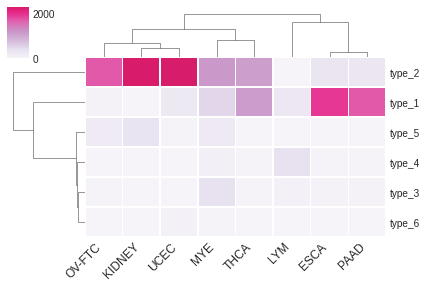

In [ ]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
new_blues=sns.color_palette("PuRd", 1000)[0:700]
g=sns.clustermap(result2_count.T,
      #standard_scale=10,
      cmap=new_blues,
      linewidths=.5,annot_kws={"size": 15},figsize=(6,4),
      )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12,rotation=45, horizontalalignment='right',)
plt.savefig("fig3_d.png",dpi=300,bbox_inches = 'tight')

In [ ]:
i='THCA'
a1=pair_total[pair_total==5].index.tolist()
a2=cancer_slope[i].index.tolist()
ret3=list(set(a1).intersection(a2))


In [ ]:
cancer_count[ret3]

,ZNF665-ZNF701,FGD4-TRIM45,CDCA8-NUDC,ATM-ZBTB32,CENPU-MCM2,CHEK1-PRKDC,PTEN-PITPNM2,CASP3-EPHB1,BTK-CDH1,TRIM63-ZP3,...,OS9-RPP40,FANCD2-GYPC,FARP1-UPP1,KCNQ3-TFB1M,CYP2D6-TNFRSF9,ANKRD11-S100A5,LMNB1-SULT1C4,ACHE-ATG5,CDKL3-NRAS,CSF2RB-PTCD1
ESCA,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
KIDNEY,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
LYM,0,0,0,1,1,1,0,0,0,0,...,1,1,1,0,0,0,0,1,0,1
MYE,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,0,1,1,1
OV-FTC,1,1,1,0,1,1,0,1,0,0,...,1,1,1,1,1,0,1,1,1,1
PAAD,1,0,1,1,1,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
THCA,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
UCEC,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
sns.heatmap(cancer_count[ret3],
      cmap=new_blues,
      linewidths=.5,annot_kws={"size": 15},ax=ax,
      )


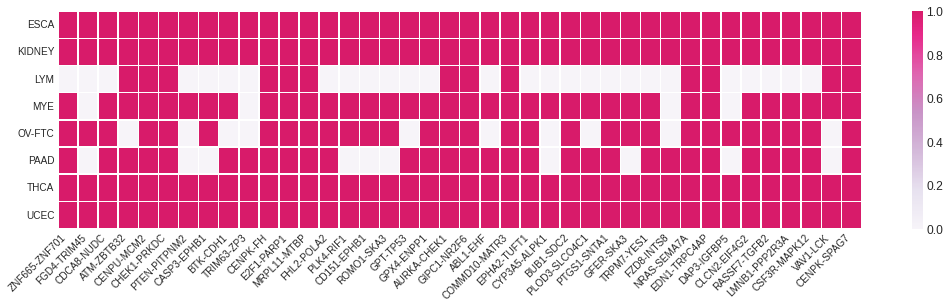

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))         # Sample figsize in inches
new_blues=sns.color_palette("PuRd", 1000)[0:700]
g=sns.heatmap(cancer_count[ret3].iloc[:,0:40],
      cmap=new_blues,
      linewidths=.5,annot_kws={"size": 15},ax=ax,
      )
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10,rotation=45, horizontalalignment='right',)
#g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15,rotation=360)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=12)
plt.savefig("fig3_e.png",dpi=300,bbox_inches = 'tight')

## epression analysis

In [ ]:
def get_SL_result_normal(adata,cancer,trajectory):
  print('......Analysis SL_count')
  xl=adata.var.index.tolist()
  SL=pd.DataFrame(columns=['gene1','gene2'])
  ret3= list(set(xl).intersection(SL_pd['gene1'].values))
  for i in ret3:
    ret4=list(set(ret3).intersection(SL_pd.loc[SL_pd['gene1']==i]['gene2'].values))
    for j in ret4: 
      SL=SL.append({'gene1':i,'gene2':j},ignore_index=True)

  ret5= list(set(xl).intersection(SL_pd['gene2'].values))
  for i in ret5:
    ret6=list(set(ret5).intersection(SL_pd.loc[SL_pd['gene2']==i]['gene1'].values))
    for j in ret6: 
      SL=SL.append({'gene1':j,'gene2':i},ignore_index=True)
  SL=SL.drop_duplicates(keep='first')

  sl_len=len(SL)
  for i in range(sl_len):
    if(i==sl_len):
      break
    if(SL.iloc[i]['gene1']==SL.iloc[i]['gene2']):
      print(i)
      SL=SL.drop(SL.iloc[i].name)
      sl_len-=1


  SL_li=SL['gene1'].values.tolist()+SL['gene2'].values.tolist()
  SL_li=list(set(SL_li))
  #Count
  SL_count=pd.DataFrame()
  SL_count['X']=adata.obs.dpt_pseudotime
  for i in SL_li:
    SL_count[i]=adata[:,i].X
  SL_count_sort=SL_count.sort_values(by='X')

  print('......Analysis SL_slope')
  import scipy.stats as stats
  slope_pd=pd.DataFrame(columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err','average','active','sig'])
  for i in SL_count_sort.columns[1:]: 
    if len(SL_count_sort[SL_count_sort[i]!=0].values)==0:
      slope, intercept, r_value, p_value, std_err=0,0,0,0,0
    else:  
      slope, intercept, r_value, p_value, std_err=stats.linregress(SL_count_sort[SL_count_sort[i]!=0]['X'].values, SL_count_sort[SL_count_sort[i]!=0][i].values)
    average=np.average(SL_count_sort[i].values)
    active='T'
    if(average <0.01 and average>-0.01):
      active='F'
    sig='normal'
    #cs=mk.original_test(SL_count_sort[SL_count_sort[i]!=0][i].values)
    if(slope>0):
      sig='high'
    elif(slope<0):
      sig='low'
    slope_pd.loc[i]=[slope, intercept, r_value, p_value, std_err,average,active,sig]
  #
  print('......Analysis SL_p')
  SL_p=pd.DataFrame(columns=['dp','type'])
  for i in range(len(SL)):
    test=[]
    g1,g2=(SL.iloc[i]['gene1']),(SL.iloc[i]['gene2'])
    #test.append(SL_count_sort[g1].values)
    #test.append(SL_count_sort[g2].values)
    #test=np.array(test)
    ty=0
    if(slope_pd.loc[g1]['active']=='T' and slope_pd.loc[g1]['sig']=='high'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=1
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=4
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=3
    if(slope_pd.loc[g1]['active']=='T' and slope_pd.loc[g1]['sig']=='low'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=2
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=3
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=5
    if(slope_pd.loc[g1]['active']=='F'):
      if(slope_pd.loc[g2]['active']=='F'):
        ty=6
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='high'):
        ty=1
      elif(slope_pd.loc[g2]['active']=='T' and slope_pd.loc[g2]['sig']=='low'):
        ty=2

    SL_p.loc[g1+'-'+g2]={'dp':slope_pd.loc[g1]['slope']-slope_pd.loc[g2]['slope'],'type':ty}
    #PCA(n_components=1).fit_transform(test.T).T[0]
  SL_p.head()

  SL_count_sort.to_csv('/content/drive/MyDrive/SL/data/normal_result/{0}_{1}_SL_count_normal.csv'.format(cancer,trajectory))
  slope_pd.to_csv('/content/drive/MyDrive/SL/data/normal_result/{0}_{1}_SL_slope_normal.csv'.format(cancer,trajectory))
  SL_p.to_csv('/content/drive/MyDrive/SL/data/normal_result/{0}_{1}_SL_pair_type_normal.csv'.format(cancer,trajectory))
  return SL_count_sort,slope_pd,SL_p

In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
#cancer2=['esca','lym','mye','ov-ftc','paad','thca','ucec']
#cancer3=['ESCA','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
import anndata
for i in range(len(cancer1)):
  adata=anndata.read_h5ad("/content/drive/MyDrive/SL/data/dpt/{0}_dpt.h5ad".format(cancer1[i]))
  adata=adata[adata.obs['tissue']=='N']
  kidney_mono=cancer_json[cancer1[i]]['Monocyte']
  kidney_mono=list(map(str,kidney_mono))
  adata=adata[adata.obs['leiden'].isin(kidney_mono)]
  SL_count_sort1,slope_pd1,SL_p1=get_SL_result_normal(adata,cancer[i],trajectory)

......Analysis SL_count
2648
7883
12236
18991
28122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


......Analysis SL_slope


/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


......Analysis SL_p
......Analysis SL_count
2879
8736
13514
21103
31188
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2042
5941
14343
21082
......Analysis SL_slope


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


......Analysis SL_p
......Analysis SL_count
2638
7841
12185
18928
27752
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2456
7291
11384
17580
25779
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2466
7451
11504
17675
26163
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2647
7853
12260
18988
27919
......Analysis SL_slope
......Analysis SL_p
......Analysis SL_count
2679
8098
12603
19599
28754
......Analysis SL_slope
......Analysis SL_p


In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
trajectory='Monocyte'
cancer_c={}
for i in cancer:
  test_pd=pd.read_csv('/content/drive/MyDrive/SL/data/result2/{0}_{1}_SL_count.csv'.format(i,trajectory))
  test_pd.set_index(test_pd.columns[0],inplace=True)
  cancer_c[i]=test_pd


In [ ]:
cancer=['ESCA','KIDNEY','LYM','MYE','OV-FTC','PAAD','THCA','UCEC']
cancer1=['esca','KIDNEY','lym','mye','ov-ftc','paad','thca','ucec']
normal_c={}
for i in cancer:
  test_pd=pd.read_csv('/content/drive/MyDrive/SL/data/normal_result/{0}_{1}_SL_count_normal.csv'.format(i,trajectory))
  test_pd.set_index(test_pd.columns[0],inplace=True)
  normal_c[i]=test_pd

In [ ]:
def get_disdata_cancer(genelist):
  vio_data=pd.DataFrame()
  #print(len(res[res.obs['Diagnosis']=='AD'].X.T[0]),len(res[res.obs['Diagnosis']=='Control'].X.T[0]))
  for i in genelist:
    for j in cancer:
      test_1=pd.DataFrame()
      test_1['value']=cancer_c[j][cancer_c[j][i]!=0][i].values
      test_1['gene']=[k for k in [i]*len(test_1)]
      test_1['X']=cancer_c[j][cancer_c[j][i]!=0]['X'].values
      test_1['cancer']=[k for k in [j]*len(test_1)]
      vio_data=pd.concat([vio_data,test_1],ignore_index=True)

  return vio_data

In [ ]:
def get_disdata_normal(genelist):
  vio_data=pd.DataFrame()
  #print(len(res[res.obs['Diagnosis']=='AD'].X.T[0]),len(res[res.obs['Diagnosis']=='Control'].X.T[0]))
  for i in genelist:
    for j in cancer:
      test_1=pd.DataFrame()
      test_1['value']=normal_c[j][normal_c[j][i]!=0][i].values
      test_1['gene']=[k for k in [i]*len(test_1)]
      test_1['X']=normal_c[j][normal_c[j][i]!=0]['X'].values
      test_1['cancer']=[k for k in [j]*len(test_1)]
      vio_data=pd.concat([vio_data,test_1],ignore_index=True)

  return vio_data

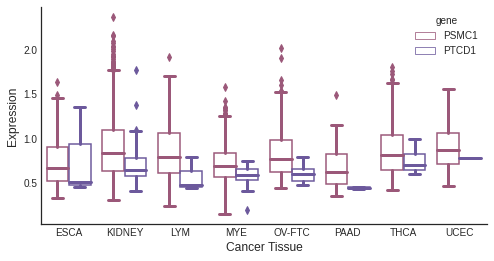

In [ ]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(8,4))

#plot_data=get_fc(res_mg_atac.var.loc[mg_res_atac.loc[mg_res_atac['abs_weights']>0.8].index.values]['transcript_annotation'].values)

g=sns.boxplot(x="cancer", y="value", hue='gene',data=get_disdata_cancer(['PSMC1','PTCD1']), 
        palette=["#a64d79","#674ea7"],
        
        ax=ax,     
              )

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(3)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
# Add in points to show each observation
#sns.stripplot(x="cancer", y="value", hue='gene',data=get_disdata_cancer(['ZNF550','KRAS']),
#              palette=["#f2535d","#a2ebc4"],
#              size=4, color=".3", linewidth=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Cancer Tissue',fontsize=12)
plt.ylabel('Expression',fontsize=12)
plt.savefig("fig3_f.png",dpi=300,bbox_inches = 'tight')

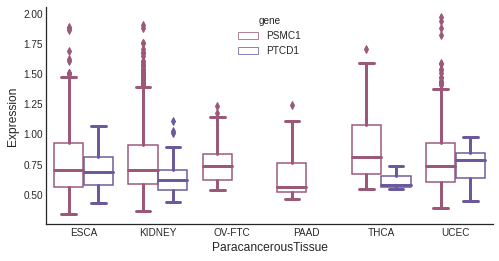

In [ ]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(8,4))

#plot_data=get_fc(res_mg_atac.var.loc[mg_res_atac.loc[mg_res_atac['abs_weights']>0.8].index.values]['transcript_annotation'].values)

g=sns.boxplot(x="cancer", y="value", hue='gene',data=get_disdata_normal(['PSMC1','PTCD1']), 
        palette=["#a64d79","#674ea7"],
        
        ax=ax,     
              )

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(3)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
# Add in points to show each observation
#sns.stripplot(x="cancer", y="value", hue='gene',data=get_disdata_cancer(['ZNF550','KRAS']),
#              palette=["#f2535d","#a2ebc4"],
#              size=4, color=".3", linewidth=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('ParacancerousTissue',fontsize=12)
plt.ylabel('Expression',fontsize=12)
plt.savefig("fig3_g.png",dpi=300,bbox_inches = 'tight')